In [1]:
import numpy as np
import keras
from matplotlib import pyplot as plt
from scipy.io import loadmat #библиотека для загрузки .mat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [2]:
#np.random.seed(10)


In [3]:
from google.colab import drive #монтируем виртуальный диск для доступа к загруженным данным
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train_data = loadmat('/content/gdrive/MyDrive/Colab Notebooks/train_32x32.mat')
test_data = loadmat('/content/gdrive/MyDrive/Colab Notebooks/test_32x32.mat')

In [5]:
train_img = np.array(train_data['X']) # заносим данные в массив
test_img = np.array(test_data['X'])

train_labels = train_data['y']
test_labels = test_data['y']

In [6]:
print(train_img.shape)
print(test_img.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [7]:
train_img = np.moveaxis(train_img, -1, 0)
test_img = np.moveaxis(test_img, -1, 0)

                                                      #переделаем для нужд keras
print(train_img.shape)
print(test_img.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


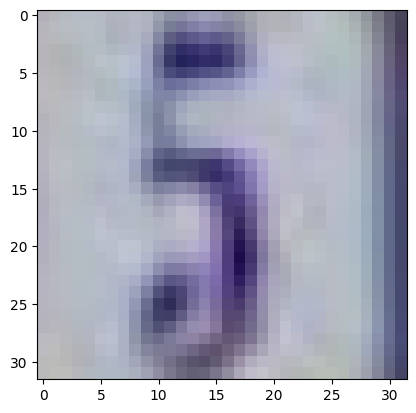

[5]


In [10]:
plt.imshow(train_img[7212])
plt.show()
print(train_labels[7212])

In [11]:
train_img = train_img.astype('float64')
test_img = test_img.astype('float64')

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [12]:
train_img /= 255.0 #нормализуем массивы
test_img /= 255.0#кодируем в 0 и 1

In [13]:
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)#адаптация модели к данным и преобразование
test_labels = lb.fit_transform(test_labels)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(train_img, train_labels,
                                                  test_size=0.15, random_state=10)

In [15]:
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)#предобработка изображений

In [17]:
keras.backend.clear_session()#Сбрасывает все состояния, созданные Keras
#настройка слоев
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same',
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(64, (3, 3), padding='same',
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, (3, 3), padding='same',
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)#Прекратить обучение, когда метрика перестала улучшаться.
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True) #оптимизатор Адам - самый оптимальный
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/kaggle/working/best_cnn.h5',
                   save_best_only=True)#сохранить ту модель, что достигла наилучший результат
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=10, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/10


<ipython-input-18-7470399bbdfb>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),


487/487 [==============================] - 317s 646ms/step - loss: 2.1802 - accuracy: 0.2041 - val_loss: 1.6876 - val_accuracy: 0.3780


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
487/487 [==============================] - 314s 645ms/step - loss: 1.6230 - accuracy: 0.3984 - val_loss: 0.8740 - val_accuracy: 0.7205
Epoch 3/10
487/487 [==============================] - 309s 636ms/step - loss: 1.0369 - accuracy: 0.6392 - val_loss: 0.5183 - val_accuracy: 0.8395
Epoch 4/10
487/487 [==============================] - 308s 632ms/step - loss: 0.5719 - accuracy: 0.8321 - val_loss: 0.3102 - val_accuracy: 0.9086
Epoch 5/10
487/487 [==============================] - 311s 639ms/step - loss: 0.4462 - accuracy: 0.8728 - val_loss: 0.3064 - val_accuracy: 0.9145
Epoch 6/10
487/487 [==============================] - 311s 638ms/step - loss: 0.3876 - accuracy: 0.8900 - val_loss: 0.3017 - val_accuracy: 0.9124
Epoch 7/10
487/487 [==============================] - 312s 639ms/step - loss: 0.3531 - accuracy: 0.8997 - val_loss: 0.2652 - val_accuracy: 0.9276
Epoch 8/10
487/487 [==============================] - 314s 645ms/step - loss: 0.3265 - accuracy: 0.9071 - val_loss: 0.2597 -

In [19]:
test_loss, test_acc = model.evaluate(x=test_img, y=test_labels, verbose=0)

print('Точность: {:0.4f} \nПотери is: {:0.4f}'.format(test_acc, test_loss))# узнаем точность и потери

Точность: 0.9347 
Потери is: 0.2424


1/1 [==============================] - 0s 15ms/step
[[2.0747991e-06 2.9719004e-07 1.0366444e-08 9.9999750e-01 2.7246367e-09
  7.8580564e-09 1.7255251e-08 9.7210400e-09 7.9851370e-09 4.9572213e-10]]


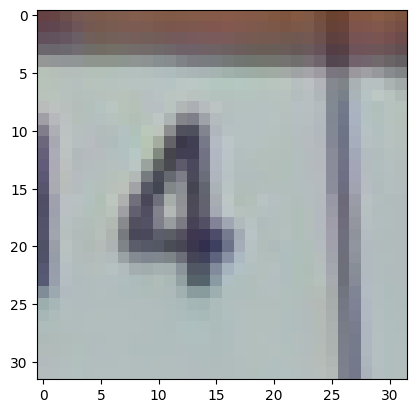

In [55]:
k = 15566
plt.imshow(test_img[k])
print(model.predict(np.array([test_img[k]])))

In [54]:
print( np.argmax(model.predict(np.array([test_img[k]])))+1 )

1/1 [==============================] - 0s 15ms/step
4
